# Frequency-Domain BSS -- Boilerplate



In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
BASE_PATH = '/content/drive/My Drive/blind_source_separation/'
sys.path.append(BASE_PATH)

import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from scipy.signal import stft
from scipy.io import wavfile
import scipy
import numpy as np
import matplotlib.pyplot as plt

# Load Wave Files

https://cnl.salk.edu/~tewon/Blind/blind_audio.html

In [3]:
fs, waveA = wavfile.read(os.path.join(BASE_PATH,'data/mixed/rss_mA.wav'))
_, waveB = wavfile.read(os.path.join(BASE_PATH,'data/mixed/rss_mB.wav'))

X = np.vstack([waveA,waveB])

print(X.shape)
print(fs)
print(type(fs))
print(waveA.dtype)
print(waveA.shape)
print(waveB.dtype)
print(waveB.shape)

(2, 119000)
16000
<class 'int'>
int16
(119000,)
int16
(119000,)


# STFT

Zxx: STFT of x. By default, the last axis of Zxx corresponds to the segment times.

t: Array of segment times.

f: Array of sample frequencies.

In [4]:
f, t, Zxx = stft(X, fs, nperseg=2500)
print(f.shape)
print(t.shape)
print(Zxx.shape)
print(Zxx.dtype)

(1251,)
(97,)
(2, 1251, 97)
complex64


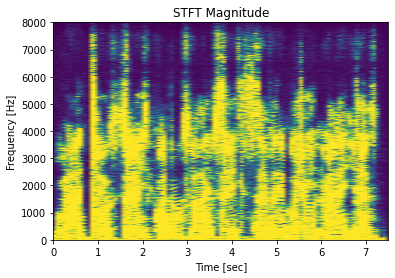

In [5]:
vmax=10
plt.pcolormesh(t, f, np.abs(Zxx[0]), vmin=0, vmax=vmax, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [6]:
sys.path.append(os.path.join(BASE_PATH,'modules'))
from separation import *

In [7]:
from tqdm.notebook import trange, tqdm
from time import sleep

def source_separation(Zxx, f, Wf=[], Yf=[]):
  for i in trange(len(f), desc='1st loop'):
    x_f = Zxx[:,i,:]
    V, Z = whitening(x_f)
    U, Y = complex_FastICA(Z, history=False)
    W, Y = MLE(x_f, V, U, max_iter=int(1e3), step_size=1e-4, tol=1e-6, history=False)
    Wf.append([W, f[i]])
    Yf.append([Y, f[i]])
  return Wf, Yf

In [8]:
Wf, Yf = source_separation(Zxx, f)

/content/drive/My Drive/blind_source_separation/modules/separation.py:107: UserWarning: MLE did not converge.
  warnings.warn('MLE did not converge.')
/content/drive/My Drive/blind_source_separation/modules/separation.py:66: UserWarning: FastICA did not converge.
  warnings.warn('FastICA did not converge.')


# TDOA: Permutation problem

In [9]:
#from importlib import reload
#reload(permutation)
from permutation import *

Cut off low frequencies. They lead to unstable estimators.

In [10]:
print(len(Wf))

1251


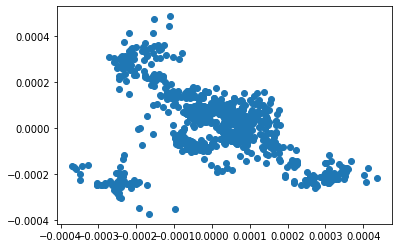

In [25]:
Wf_ = Wf[100:]

rf_est = TDOA_estimator(Wf_)

plt.scatter(rf_est[:,0],rf_est[:,1])
plt.show()